In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from pprint import pprint
from typing import Dict, Sequence

import numpy
import pandas
# import napari
import seaborn
import torch
from imageio import imread
from ruamel.yaml import YAML
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt

from hylfm.eval.metrics import compute_metrics_individually, init_metrics
yaml = YAML(typ="safe")

/g/kreshuk/beuttenm/pycharm_tmp/repos/hylfm-net/hylfm/_settings/default.py:76: UserWarning: numpy imported before hylfm. numpy env var settings won't take effect!
  warnings.warn("numpy imported before hylfm. numpy env var settings won't take effect!")


In [99]:
def get_validate_df(name, step_dirs, z_mod):
    metrics_config = yaml.load(Path("/g/kreshuk/beuttenm/pycharm_tmp/repos/hylfm-net/configs/metrics/heart_dynamic.yml"))
    metrics_instances = init_metrics(metrics_config)

    all_preds = []
    all_ls_slices = []
    pred_nrs = []
    for step_dir in tqdm(step_dirs, desc=f"load raw data for {name}"):
        assert step_dir.name == "run000"
        pred_nr = int(step_dir.parent.name.split("_")[-1])
        pred_nrs.append(pred_nr)
        ls_slices = numpy.stack([imread(p) for p in sorted(step_dir.glob("ds0-0/ls_slice/*.tif"))])
        assert (ls_slices.shape[0] % z_mod) == 0
        all_ls_slices.append(ls_slices)
        preds = numpy.stack([imread(p) for p in sorted(step_dir.glob("ds0-0/pred/*.tif"))])
        assert preds.shape == ls_slices.shape, (preds.shape, ls_slices.shape)
        all_preds.append(preds)

    data = None
    for pred_nr, preds, ls_slices in tqdm(zip(pred_nrs, all_preds, all_ls_slices), total=len(all_preds), desc=f"comp. metrics for {name}"):
        step = 0
        for idx, (pred, ls_slice) in enumerate(zip(preds, ls_slices)):
            # add batch and channel dim
            pred = pred[None, None]
            ls_slice = ls_slice[None, None]

            tensors = {"pred": torch.from_numpy(pred), "ls_slice": torch.from_numpy(ls_slice)}
            computed_metrics = {k: m.value for k, m in compute_metrics_individually(metrics_instances, tensors).items()}
            computed_metrics["idx"] = idx
            computed_metrics["pred_nr"] = pred_nr
            if data is None:
                data = {k: [v] for k, v in computed_metrics.items()}
            else:
                for mk, mv in computed_metrics.items():
                    data[mk].append(mv)

    df = pandas.DataFrame.from_dict(data)
    df["swipe_through"] = df["pred_nr"]
    df["pred_nr"] = 0
    return df

def get_refine_ls_slices(z_mod, fish2: bool):
    if fish2:
        ls_dir = Path("/g/kreshuk/beuttenm/pycharm_tmp/repos/hylfm-net/logs/test/heart/validate_fish2/from_static_heart/20-11-12_15-11-48/test_dynamic_00/run000")
    else:
        ls_dir = Path(
            "/g/kreshuk/beuttenm/pycharm_tmp/repos/hylfm-net/logs/train/heart/z_out49/dualview_single_lfm_static_f4_center49/20-11-09_18-09-02/validate_train_01/run000"
        )

    ls_slices = numpy.stack([imread(p) for p in sorted(ls_dir.glob("ds0-0/ls_slice/*.tif"))])
    assert (ls_slices.shape[0] % z_mod) == 0, (ls_slices.shape[0], z_mod)
    return ls_slices



def get_refine_df(name, step_dirs, z_mod, ls_slices):
    assert (ls_slices.shape[0] % z_mod) == 0, (ls_slices.shape[0], z_mod)

    metrics_config = yaml.load(Path("/g/kreshuk/beuttenm/pycharm_tmp/repos/hylfm-net/configs/metrics/heart_dynamic.yml"))
    metrics_instances = init_metrics(metrics_config)

    all_preds = []
    pred_nrs = []
    for step_dir in tqdm(step_dirs, desc=f"load raw data for ls_slices"):
        assert step_dir.name.startswith("run")
        pred_nr = int(step_dir.name.replace("run", ""))
        pred_nrs.append(pred_nr)

        preds = numpy.stack([imread(p) for p in sorted(step_dir.glob("ds0-0/pred/*.tif"))])
        assert preds.shape == ls_slices.shape, (preds.shape, ls_slices.shape)
        all_preds.append(preds)

    data = None
    for pred_nr, preds in zip(tqdm(pred_nrs, desc=f"comp. metrics for {name}"), all_preds):
        for idx, (pred, ls_slice) in enumerate(zip(preds, ls_slices)):
            # add batch and channel dim
            pred = pred[None, None]
            ls_slice = ls_slice[None, None]

            tensors = {"pred": torch.from_numpy(pred), "ls_slice": torch.from_numpy(ls_slice)}
            computed_metrics = {k: m.value for k, m in compute_metrics_individually(metrics_instances, tensors).items()}
            computed_metrics["idx"] = idx
            computed_metrics["pred_nr"] = pred_nr
            if data is None:
                data = {k: [v] for k, v in computed_metrics.items()}
            else:
                for mk, mv in computed_metrics.items():
                    data[mk].append(mv)

    df = pandas.DataFrame.from_dict(data)
    df["swipe_through"] = df["idx"] // z_mod
    return df

def get_df(name, *, pred_nrs = (0,), ls_slices: Dict[int, numpy.ndarray]):
    if name == "validate_from_static_heart":
        root = Path(
            # "/g/kreshuk/beuttenm/pycharm_tmp/repos/hylfm-net/logs/test/heart/z_out49/contin_validate_f4/20-11-10_14-02-53"
            "/g/kreshuk/beuttenm/pycharm_tmp/repos/hylfm-net/logs/test/heart/z_out49/contin_validate_f4/20-11-11_19-35-43"
#             "/g/kreshuk/beuttenm/pycharm_tmp/repos/hylfm-net/logs/test/heart/z_out49/contin_validate_f4/20-11-13_13-53-21" ??
        )

        assert root.exists(), root
        z_min = 29
        z_mod = 189
        step_dirs = sorted(root.glob("test_dynamic_*/run000"))
    elif name == "validate_fish2/from_static_heart":
        root = Path("/g/kreshuk/beuttenm/pycharm_tmp/repos/hylfm-net/logs/test/heart/validate_fish2/from_static_heart/20-11-12_15-11-48")
        z_min = 29
        z_mod = 189
        step_dirs = [root / "test_dynamic_00/run000"]
    elif name.startswith("refine_fish2/"):
        map_name_here = name[len("refine_fish2/"):]
        z_min = 29
        z_mod = 189
        common_root = Path("/g/kreshuk/beuttenm/pycharm_tmp/repos/hylfm-net/logs/train/heart/")
        names_map = {}
        times_map = {
            "from_bad_static_heart": "20-11-12_15-45-00",
            # "from_heart_lr": "20-11-12_15-42-08",
            "from_heart_lr": "20-11-12_17-08-03",
            # "from_medium_beads": "20-11-12_15-42-08",
            "from_medium_beads": "20-11-12_17-08-03",
            # "from_mednlarge_beads": "20-11-12_15-15-55",
            # "from_mednlarge_beads": "20-11-12_15-40-40",
            "from_mednlarge_beads": "20-11-12_17-07-40",
            # "from_static_heart": "20-11-12_15-42-07",
            "from_static_heart": "20-11-12_17-08-02",
         }
        root = common_root / names_map.get(map_name_here, name) / times_map[map_name_here]
        assert root.exists(), root
        step_dirs = sorted(root.glob("validate_train_01/run*"))[:-1]
    elif name.startswith("refine_from"):
        z_min = 29
        z_mod = 189
        common_root = Path("/g/kreshuk/beuttenm/pycharm_tmp/repos/hylfm-net/logs/train/heart/z_out49/")
        names_map = {"refine_from_lfd_heart": "dualview_single_lfm_static_f4_center49"}
        times_map = {
            "refine_from_bad_static_heart": "20-11-11_20-00-16",
            "refine_from_lfd_heart": "20-11-09_18-09-02",
            "refine_from_medium_beads": "20-11-11_13-09-30",
            "refine_from_mednlarge_beads": "20-11-11_19-55-02",
            "refine_from_static_heart": "20-11-11_19-48-09",
        }
        root = common_root / names_map.get(name, name) / times_map[name]
        assert root.exists(), root
        step_dirs = sorted(root.glob("validate_train_01/run*"))[:-1]
    else:
        raise NotImplementedError(name)

    if name.startswith("validate_from"):
        # if "from_static" in name:
        #     def idx2z(idx):
        #         return z_min + (idx % z_mod)
        # else:
        #     raise NotImplementedError(name)
        _get_df = get_validate_df
#         step_dirs = step_dirs[:4]
        get_df_kwargs = {}
    elif name.startswith("refine") or name.startswith("validate_fish2"):
        _get_df = get_refine_df
        step_dirs = numpy.asarray(step_dirs)[pred_nrs]

        if (z_mod, "fish2" in name) not in ls_slices:
            ls_slices[z_mod] = get_refine_ls_slices(z_mod, "fish2" in name)

        get_df_kwargs = {"ls_slices": ls_slices[z_mod]}
    else:
        raise NotImplementedError(name)

    def idx2z(idx):
        return z_min + z_mod - 1 - (idx % z_mod)

    df = _get_df(name, step_dirs, z_mod, **get_df_kwargs)
    df["z"] = df["idx"].apply(idx2z) - 120
    df["frame"] = df["swipe_through"] * 241 + 120 - df["z"]
    df["time [s]"] = df["frame"] * 0.025
    df["run_name"] = name
    return df

def add_df(df, name, pred_nrs, ls_slices):
    dfs = [df, get_df(name, pred_nrs=pred_nrs, ls_slices=ls_slices)]
    return pandas.concat(dfs)

def get_dfs(*names, pred_nrs):
    dfs = []
    ls_slices = {}
    for name in names:
        dfs.append(get_df(name, pred_nrs=pred_nrs, ls_slices=ls_slices))

    return pandas.concat(dfs), ls_slices

In [107]:
df, ls_slices = get_dfs("refine_fish2/from_static_heart", pred_nrs=[0])
df.head()

comp. metrics for refine_fish2/from_static_heart: 100%|██████████| 1/1 [00:41<00:00, 41.90s/it]


,smooth_l1_loss-scaled,ms_ssim-scaled,ssim-scaled,nrmse-scaled,psnr-scaled,mse_loss-scaled,idx,pred_nr,swipe_through,z,frame,time [s],run_name
0,0.000219,0.913215,0.840901,0.584725,33.576915,0.000439,0,1,0,97,23,0.575,refine_fish2/from_static_heart
1,0.000157,0.922880,0.857644,0.598548,35.038612,0.000313,1,1,0,96,24,0.600,refine_fish2/from_static_heart
2,0.000075,0.949792,0.898637,0.583410,38.230164,0.000150,2,1,0,95,25,0.625,refine_fish2/from_static_heart
3,0.000045,0.959511,0.916508,0.589459,40.463557,0.000090,3,1,0,94,26,0.650,refine_fish2/from_static_heart
4,0.000032,0.967391,0.923860,0.592707,41.901803,0.000065,4,1,0,93,27,0.675,refine_fish2/from_static_heart


In [117]:
df = add_df(df, "refine_fish2/from_static_heart", pred_nrs=[0], ls_slices=ls_slices)

comp. metrics for refine_fish2/from_static_heart: 100%|██████████| 1/1 [01:03<00:00, 63.53s/it]


In [108]:
df = add_df(df, "refine_fish2/from_heart_lr", pred_nrs=[0], ls_slices=ls_slices)
df = add_df(df, "refine_fish2/from_medium_beads", pred_nrs=[0], ls_slices=ls_slices)

comp. metrics for refine_fish2/from_medium_beads: 100%|██████████| 1/1 [00:43<00:00, 43.13s/it]


In [135]:
df = add_df(df, "refine_fish2/from_static_heart", pred_nrs=[1, 10, 100], ls_slices=ls_slices)
df = add_df(df, "refine_fish2/from_heart_lr", pred_nrs=[1, 10, 100], ls_slices=ls_slices)
df = add_df(df, "refine_fish2/from_medium_beads", pred_nrs=[1, 10, 100], ls_slices=ls_slices)

comp. metrics for refine_fish2/from_medium_beads: 100%|██████████| 3/3 [02:00<00:00, 40.24s/it]


In [133]:
df_filtered_not_refined_yet = df[df.pred_nr == 0]
df_filtered_not_refined_yet.frame.min(), df_filtered_not_refined_yet.frame.max(), df_filtered_not_refined_yet.z.min(), df_filtered_not_refined_yet.z.max()

(23, 934, -91, 97)

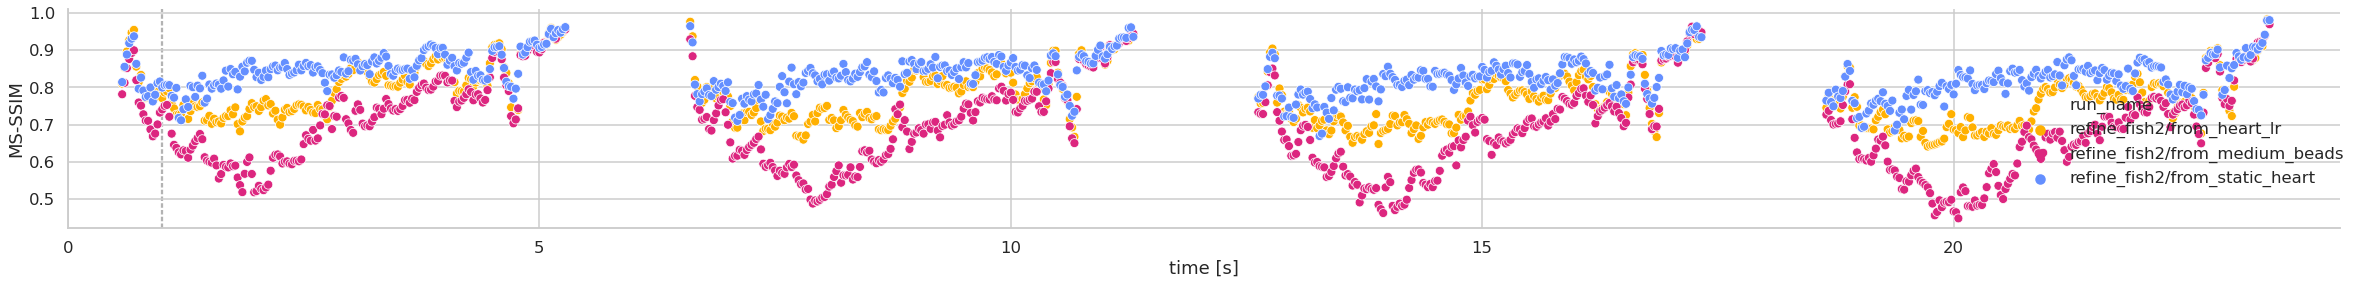

In [160]:
# z_line_at = 80
# def plot_not_refined_yet(metric: str):
#     seaborn.set_style("whitegrid") #, {"axes.facecolor": ".8"})
#     seaborn.set_context("talk")  # paper, notebook, talk, poster
#     g = seaborn.relplot(
#         x="time [s]",
#         y=metric,
#         hue="run_name",
# #         legend=False, # False, brief, full
#         palette=["#FFB000", "#DC267F","#648FFF"], #"colorblind", #cmap_name,  #FFB000, #FE6100, #DC267F, #785EF0 #648FFF
#         height=4, aspect=7,
#         kind="scatter",
#         data=df_filtered_not_refined_yet,
#     )
#     g.map(plt.axvline, x=(120 - z_line_at) * 0.025, color=".7", dashes=(2, 1), zorder=0)
#     g.set_axis_labels("time [s]", "MS-SSIM")  # z [μm] 
#     g.fig.axes[0].set_xlim(0, 4*241*0.025)
# #     plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     root = Path("plot_not_refined_yet")
#     root.mkdir(exist_ok=True)
#     g.fig.savefig(root / f"{metric}.png")
#     g.fig.savefig(root / f"{metric}.svg")

# plot_not_refined_yet("ms_ssim-scaled")

In [175]:
df_filtered = df[(df.swipe_through == 0) & (df.pred_nr >= 0)]
df_filtered.z.min(), df_filtered.z.max()

(-91, 97)

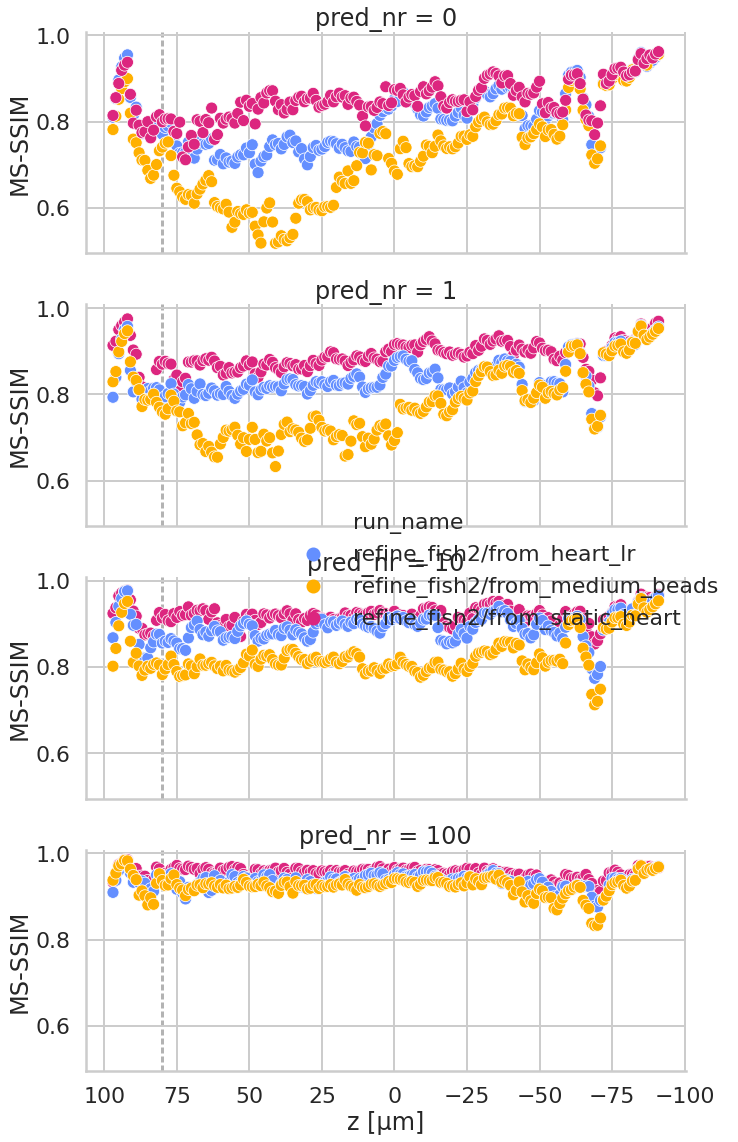

In [177]:
def plot_refinement(metric: str):
    seaborn.set_style("whitegrid") #, {"axes.facecolor": ".8"})
    seaborn.set_context("poster")  # paper, notebook, talk, poster
    cmap_name = "viridis"
    g = seaborn.relplot(
        x = "z",
        y=metric,
        hue="run_name",
#         legend=False, # False, brief, full
        row="pred_nr",
#         col="swipe_through",
        palette=["#648FFF", "#FFB000", "#DC267F"], #"colorblind", #cmap_name,  #FFB000, #FE6100, #DC267F, #785EF0 #648FFF
        height=4, aspect=1,
        kind="scatter",
        data=df_filtered,
    )
    plt.xlim(reversed(plt.xlim()))
    g.map(plt.axvline, x=z_line_at, color=".7", dashes=(2, 1), zorder=0)
    g.set_axis_labels("z [μm]", "MS-SSIM")  # z [μm] 
#     g.fig.axes[0].set_xlim(-120, 120)
#     plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     g.fig.tight_layout()
    root = Path("plot_refinement")
    root.mkdir(exist_ok=True)
    g.fig.savefig(root / f"{metric}.png")
    g.fig.savefig(root / f"{metric}.svg")

plot_refinement("ms_ssim-scaled")

In [178]:
target_height = 252

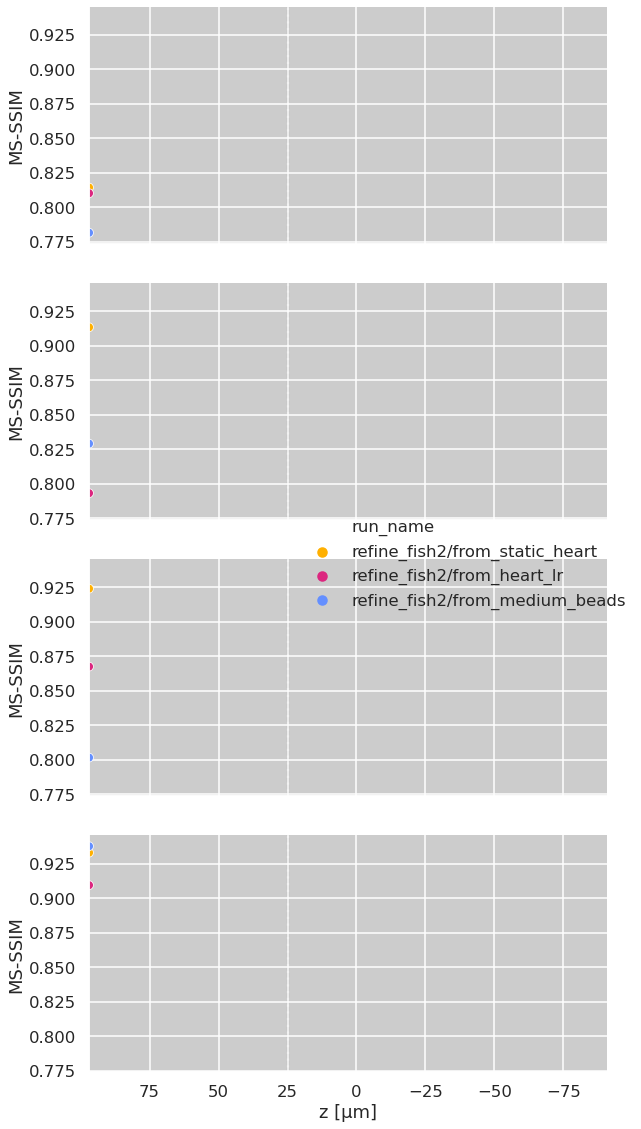

In [179]:
z_min_plot = df_filtered.z.min()
z_max_plot = df_filtered.z.max()

def plot_video_frame(metric: str, sw, z, i):
    seaborn.set_style("darkgrid", {"axes.facecolor": ".8"})
    seaborn.set_context("talk")  # paper, notebook, talk, poster
#     cmap_name = "viridis"
    g = seaborn.relplot(
        x="z",
        y=metric,
        hue="run_name",
        legend="brief",  # brief, full
        row="pred_nr",
#         col="swipe_through",
        palette=["#FFB000", "#DC267F","#648FFF"],
        height=4, aspect=1,
        kind="scatter",
        data=df_filtered[(df_filtered.swipe_through == sw) & (df_filtered.z >= z)]
    )
    g.map(plt.axvline, x=25, color=".7", dashes=(2, 1), zorder=0)
    g.set_axis_labels("z [μm]", "MS-SSIM")
    g.set_titles("")  # 
    g.fig.axes[0].set_xlim(z_min_plot, z_max_plot)
    plt.xlim(reversed(plt.xlim()))
    root = Path("plot_video_frame")
    root.mkdir(exist_ok=True)
    g.fig.savefig(root / f"{metric}_sw{sw}_i{i:0f}_z{z}.png")



z_min = df_filtered.z.max() - 1 # df_filtered.z.min() - 1
for sw in range(1):
    for i, z in enumerate(range(df_filtered.z.max(), z_min, -1)):
        plot_video_frame("ms_ssim-scaled", sw, z, i)

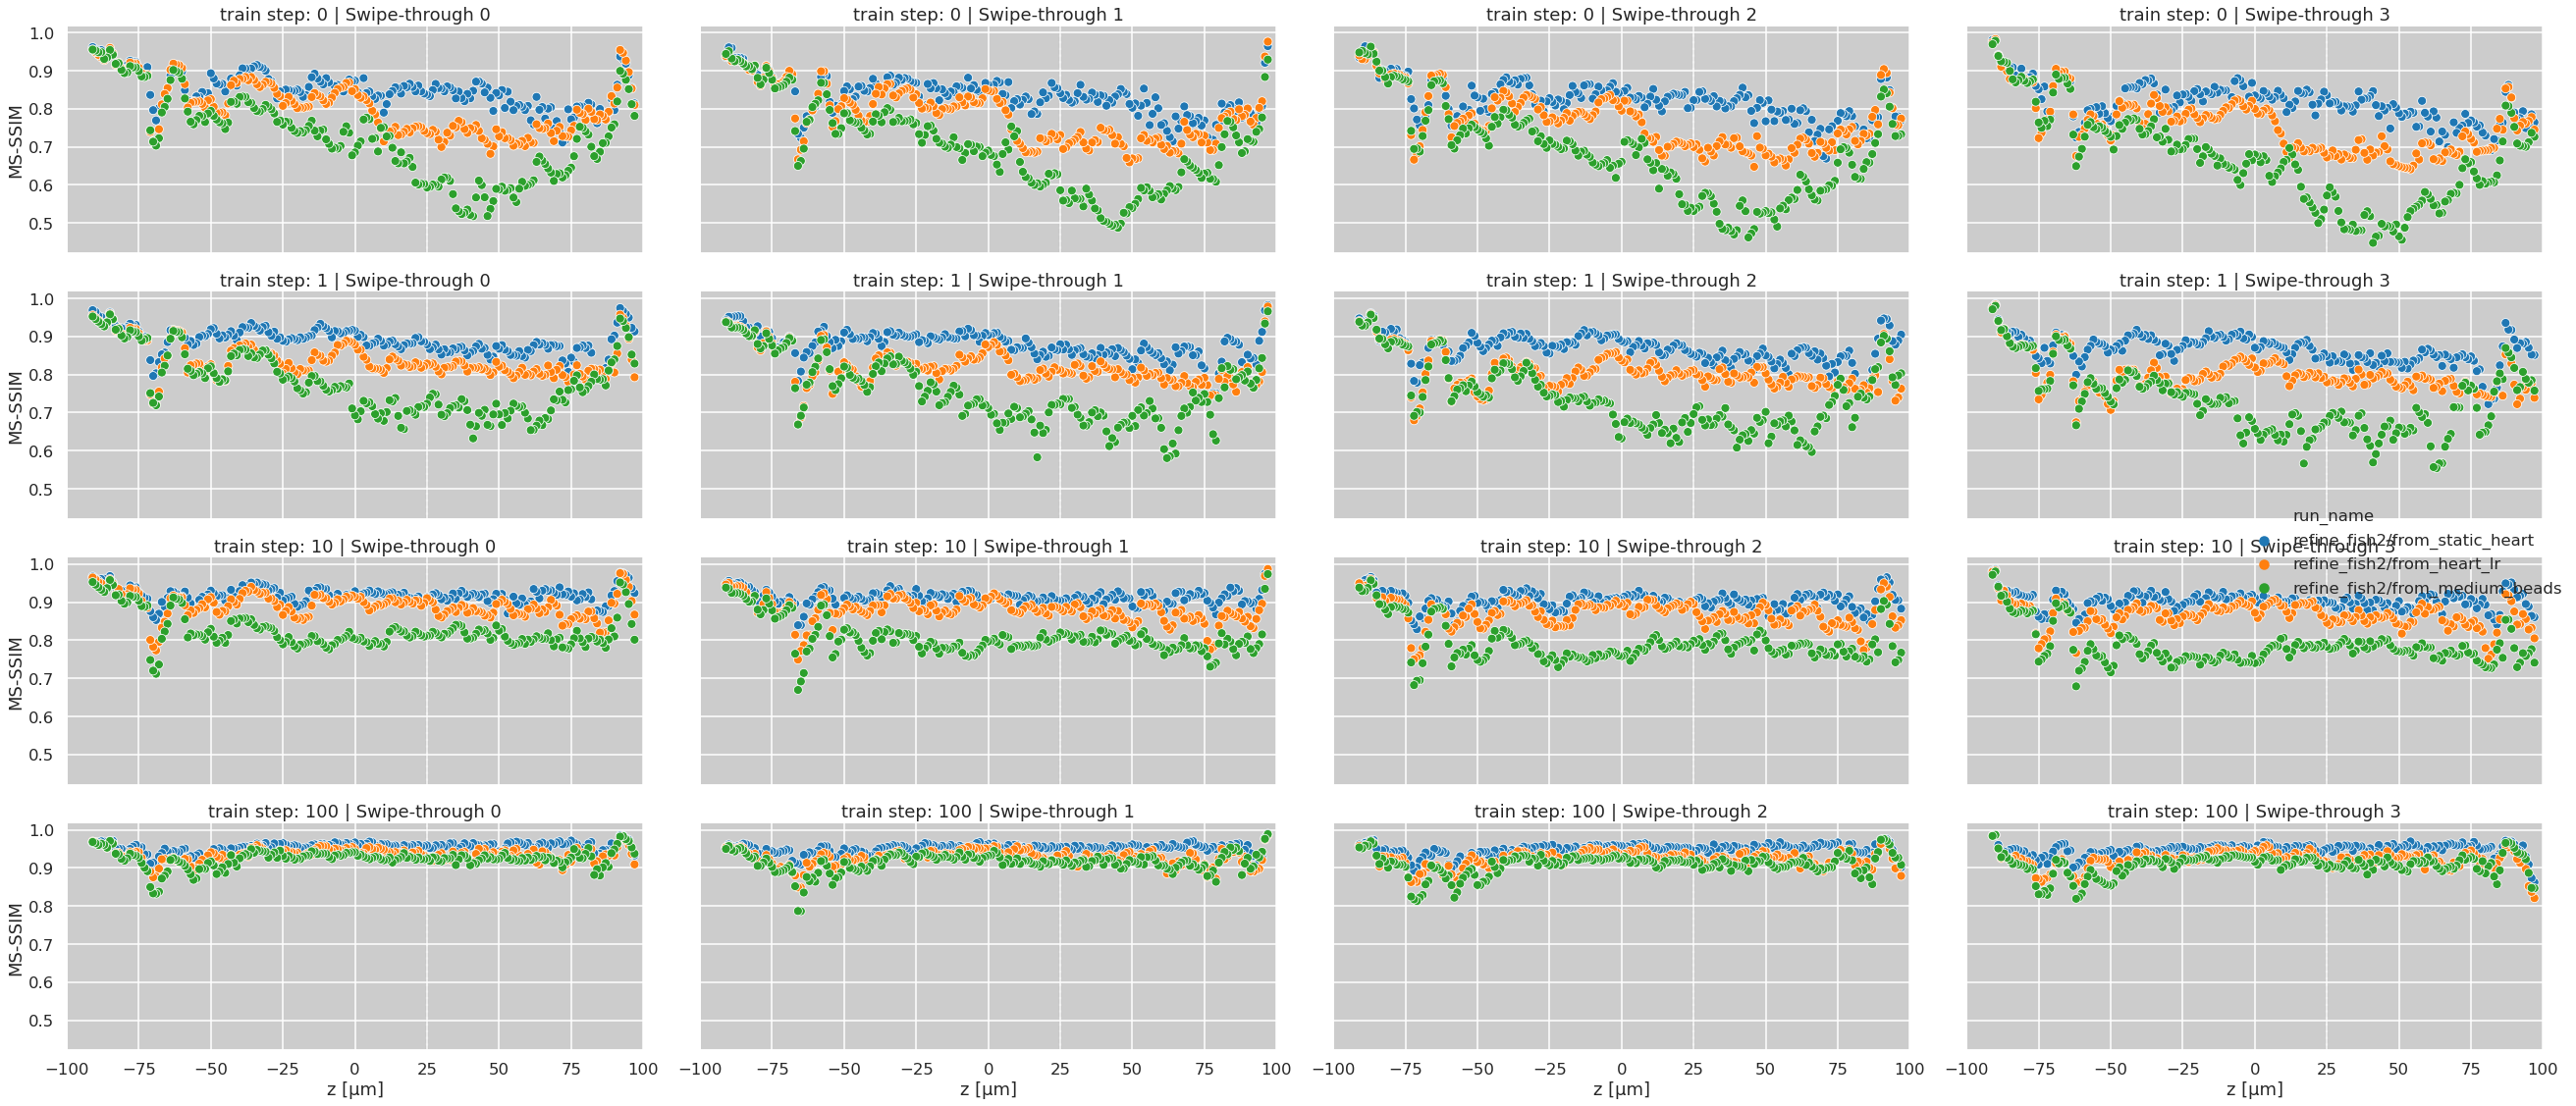

In [15]:
# def plot_scans_grid(metric: str):
#     seaborn.set_style("darkgrid", {"axes.facecolor": ".8"})
#     seaborn.set_context("talk")  # paper, notebook, talk, poster
#     cmap_name = "viridis"
#     g = seaborn.relplot(
#         x="z",
#         y=metric,
#         hue="run_name",
#         legend="brief",  # brief, full
#         row="pred_nr",
#         col="swipe_through",
# #         palette=cmap_name,
#         height=4, aspect=2,
#         kind="scatter",
#         data=df_filtered
#     )
#     g.map(plt.axvline, x=25, color=".7", dashes=(2, 1), zorder=0).set_axis_labels("z [μm]", "MS-SSIM").set_titles("train step: {row_name} | Swipe-through {col_name}")#.tight_layout(w_pad=0)
#     # g.add_legend()
# #     for ax in g.axes:
# #         g.fig.colorbar(matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(vmin=z_offset, vmax=df["z"].max()+z_offset, clip=False), cmap=cmap_name), label='z', ax=ax)
# #         ax.set_xlim([-z_range_value * 1.1, z_range_value * 1.1])
# #         ax.set_ylim([-z_range_value * 1.1, z_range_value * 1.1])
# #         ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
# #     g.fig.colorbar(matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(vmin=z_offset, vmax=df["z"].max()+z_offset, clip=False), cmap=cmap_name), label='z')
# #     g.fig.axes[0].set_xlim(0, 9399*0.025)
#     g.fig.axes[0].set_xlim(-100, 100)
#     g.fig.tight_layout()
#     root = Path("refine_lfd_training_plots")
#     root.mkdir(exist_ok=True)
#     g.fig.savefig(root / f"{metric}.png")

# plot_scans_grid("ms_ssim-scaled")

In [ ]:
# plot_scans_grid("ms_ssim-scaled")
# plot_scans_grid("ssim-scaled")
# plot_scans_grid("nrmse-scaled")
# plot_scans_grid("psnr-scaled")
# plot_scans_grid("mse_loss-scaled")
# plot_scans_grid("smooth_l1_loss-scaled")